In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from pathlib import Path

In [2]:
# Define paths
BASE_DIR = Path(".") # Current directory (mediqa-magic-v2)
OUTPUT_DIR = BASE_DIR / "outputs"
DATASET_DIR = BASE_DIR / "2025_dataset"
VALID_DIR = DATASET_DIR / "valid"
TRAIN_DIR = DATASET_DIR / "train"

# Load prediction file
prediction_file = OUTPUT_DIR / "data_cvqa_sys_reasoned_all_20250430_153412.json"
with open(prediction_file, 'r', encoding='utf-8') as f:
    predictions = json.load(f)
    
# Load ground truth file
gt_file = VALID_DIR / "valid_cvqa.json"
with open(gt_file, 'r', encoding='utf-8') as f:
    ground_truth = json.load(f)
    
# Load question definitions
question_def_file = TRAIN_DIR / "closedquestions_definitions_imageclef2025.json"
with open(question_def_file, 'r', encoding='utf-8') as f:
    question_defs = json.load(f)

print(f"Loaded {len(predictions)} predictions")
print(f"Loaded {len(ground_truth)} ground truth samples")
print(f"Loaded {len(question_defs)} question definitions")

Loaded 56 predictions
Loaded 56 ground truth samples
Loaded 27 question definitions


In [3]:
# Create question mapping
question_map = {}
for q in question_defs:
    qid = q['qid']
    question_map[qid] = {
        'question': q['question_en'],
        'options': q['options_en'],
        'category': q['question_category_en'],
        'type': q['question_type_en']
    }

# Display a sample of the question mapping
list(question_map.items())[0]

('CQID010-001',
 {'question': 'How much of the body is affected?',
  'options': ['single spot', 'limited area', 'widespread', 'Not mentioned'],
  'category': 'General',
  'type': 'Site'})

In [4]:
# Extract all question IDs from predictions
all_questions = set()
for pred in predictions:
    all_questions.update([k for k in pred.keys() if k != "encounter_id"])

# Identify question families (groups of related subquestions)
def identify_question_families():
    # Extract base question IDs (without the -00X suffix)
    base_questions = {}
    for qid in all_questions:
        if '-' in qid:
            base_id = qid.split('-')[0]
            if base_id not in base_questions:
                base_questions[base_id] = []
            base_questions[base_id].append(qid)
    
    # Identify families with multiple subquestions
    question_families = {base_id: sorted(subquestions) for base_id, subquestions in base_questions.items() 
                         if len(subquestions) > 1}
    
    # Special handling for known question families
    special_families = ['CQID011', 'CQID012', 'CQID020']
    
    return question_families, special_families

# Get question families
question_families, special_families = identify_question_families()

print(f"Found {len(all_questions)} unique questions")
print(f"Identified {len(question_families)} question families")
print(f"Special handling for families: {special_families}")

# Display some sample families
for family_id in special_families:
    if family_id in question_families:
        print(f"\n{family_id} subquestions: {question_families[family_id]}")

Found 27 unique questions
Identified 3 question families
Special handling for families: ['CQID011', 'CQID012', 'CQID020']

CQID011 subquestions: ['CQID011-001', 'CQID011-002', 'CQID011-003', 'CQID011-004', 'CQID011-005', 'CQID011-006']

CQID012 subquestions: ['CQID012-001', 'CQID012-002', 'CQID012-003', 'CQID012-004', 'CQID012-005', 'CQID012-006']

CQID020 subquestions: ['CQID020-001', 'CQID020-002', 'CQID020-003', 'CQID020-004', 'CQID020-005', 'CQID020-006', 'CQID020-007', 'CQID020-008', 'CQID020-009']


In [5]:
# Calculate prediction distribution for each question
pred_distribution = defaultdict(Counter)

for pred in predictions:
    for qid in all_questions:
        if qid in pred:
            pred_distribution[qid][pred[qid]] += 1

# Calculate the ground truth distribution
gt_distribution = defaultdict(Counter)

for gt in ground_truth:
    for qid in all_questions:
        if qid in gt:
            gt_distribution[qid][gt[qid]] += 1

# Display a sample of the prediction distribution
sample_qid = list(all_questions)[0]
print(f"Sample prediction distribution for question {sample_qid}:")
pred_distribution[sample_qid]

Sample prediction distribution for question CQID020-008:


Counter({9: 56})

In [6]:
# Function to convert numerical predictions to text options
def convert_to_text(qid, value):
    if qid in question_map and value < len(question_map[qid]['options']):
        return question_map[qid]['options'][value]
    return f"Unknown ({value})"

# Convert prediction distributions to text
pred_text_dist = {}
for qid, counter in pred_distribution.items():
    pred_text_dist[qid] = {convert_to_text(qid, value): count for value, count in counter.items()}

# Convert ground truth distributions to text
gt_text_dist = {}
for qid, counter in gt_distribution.items():
    gt_text_dist[qid] = {convert_to_text(qid, value): count for value, count in counter.items()}

# Display a sample of the text distribution
print(f"Sample text distribution for question {sample_qid}:")
pred_text_dist[sample_qid]

Sample text distribution for question CQID020-008:


{'Not mentioned': 56}

In [7]:
# Create mappings from encounter_id to predictions and ground truth
pred_dict = {pred['encounter_id']: pred for pred in predictions}
gt_dict = {gt['encounter_id']: gt for gt in ground_truth}

# Calculate accuracy for each question
question_accuracy = {}
question_errors = {}

for qid in all_questions:
    correct = 0
    total = 0
    errors = []
    
    for encounter_id in set(pred_dict.keys()).intersection(gt_dict.keys()):
        pred = pred_dict[encounter_id]
        gt = gt_dict[encounter_id]
        
        if qid in pred and qid in gt:
            total += 1
            if pred[qid] == gt[qid]:
                correct += 1
            else:
                errors.append({
                    'encounter_id': encounter_id,
                    'pred': convert_to_text(qid, pred[qid]),
                    'gt': convert_to_text(qid, gt[qid])
                })
    
    if total > 0:
        question_accuracy[qid] = correct / total
        question_errors[qid] = errors

# Display the accuracy for each question
accuracy_df = pd.DataFrame({
    'QID': list(question_accuracy.keys()),
    'Question': [question_map[qid]['question'] if qid in question_map else qid for qid in question_accuracy.keys()],
    'Accuracy': list(question_accuracy.values()),
    'Category': [question_map[qid]['category'] if qid in question_map else 'Unknown' for qid in question_accuracy.keys()],
    'Type': [question_map[qid]['type'] if qid in question_map else 'Unknown' for qid in question_accuracy.keys()]
})

# Show the questions with highest accuracy
print("Questions with highest accuracy:")
accuracy_df.sort_values('Accuracy', ascending=False).head(10)

Questions with highest accuracy:


,QID,Question,Accuracy,Category,Type
0,CQID020-008,8 What label best describes the affected area?,1.000000,Skin Specific,Skin Description
10,CQID020-009,9 What label best describes the affected area?,1.000000,Skin Specific,Skin Description
17,CQID012-006,6 How large are the affected areas? Please spe...,1.000000,General,Size
16,CQID020-007,7 What label best describes the affected area?,1.000000,Skin Specific,Skin Description
25,CQID011-005,5 Where is the affected area?,0.982143,General,Site Location
1,CQID011-006,6 Where is the affected area?,0.982143,General,Site Location
2,CQID012-005,5 How large are the affected areas? Please spe...,0.964286,General,Size
20,CQID020-006,6 What label best describes the affected area?,0.964286,Skin Specific,Skin Description
8,CQID012-004,4 How large are the affected areas? Please spe...,0.928571,General,Size
18,CQID011-004,4 Where is the affected area?,0.910714,General,Site Location


In [8]:
# Function to analyze special question families
def analyze_question_family(family_id, subquestions):
    if family_id not in special_families:
        return None
    
    print(f"\nAnalyzing question family {family_id}:")
    
    # Get options for this family (should be the same for all subquestions)
    options = []
    not_mentioned_idx = None
    
    if subquestions[0] in question_map:
        options = question_map[subquestions[0]]['options']
        print(f"Answer options: {options}")
        
        # Find the "Not mentioned" option index
        for i, option in enumerate(options):
            if "not mentioned" in option.lower():
                not_mentioned_idx = i
                break
    
    # Track accuracy metrics and collect answer sets
    correct_sets_exact = 0  # Exact match
    total_sets = 0
    jaccard_similarities = []  # For partial credit
    pred_answer_sets = []
    gt_answer_sets = []
    
    for encounter_id in set(pred_dict.keys()).intersection(gt_dict.keys()):
        pred = pred_dict[encounter_id]
        gt = gt_dict[encounter_id]
        
        # Skip if not all subquestions exist
        if not all(qid in pred and qid in gt for qid in subquestions):
            continue
        
        # Get sets of answers (excluding "Not mentioned" padding)
        pred_set = set()
        gt_set = set()
        
        for qid in subquestions:
            pred_val = pred[qid]
            gt_val = gt[qid]
            
            # Add all answers that aren't "Not mentioned"
            # OR add "Not mentioned" if it's the only answer in the set
            if pred_val != not_mentioned_idx or len(subquestions) == 1:
                pred_set.add(pred_val)
            
            if gt_val != not_mentioned_idx or len(subquestions) == 1:
                gt_set.add(gt_val)
        
        # Special case: if all answers were "Not mentioned", add it back as a valid single answer
        if not pred_set and not_mentioned_idx is not None:
            pred_set.add(not_mentioned_idx)
        if not gt_set and not_mentioned_idx is not None:
            gt_set.add(not_mentioned_idx)
        
        # Calculate exact match (strict)
        total_sets += 1
        if pred_set == gt_set:
            correct_sets_exact += 1
        
        # Calculate Jaccard similarity (relaxed - partial credit)
        # Jaccard = size of intersection / size of union
        if pred_set or gt_set:  # Avoid division by zero
            intersection = len(pred_set.intersection(gt_set))
            union = len(pred_set.union(gt_set))
            jaccard = intersection / union if union > 0 else 0
        else:
            jaccard = 1.0  # Both empty sets
        jaccard_similarities.append(jaccard)
        
        # Store sets for distribution analysis
        pred_answer_sets.append(pred_set)
        gt_answer_sets.append(gt_set)
    
    # Calculate different accuracy metrics
    exact_accuracy = correct_sets_exact / total_sets if total_sets > 0 else 0
    mean_jaccard = sum(jaccard_similarities) / len(jaccard_similarities) if jaccard_similarities else 0
    
    print(f"Exact match accuracy: {correct_sets_exact}/{total_sets} = {exact_accuracy:.4f}")
    print(f"Jaccard similarity (partial credit): {mean_jaccard:.4f}")
    
    # Count occurrences of each option in the answer sets
    pred_option_counts = Counter()
    gt_option_counts = Counter()
    
    for pred_set in pred_answer_sets:
        for option in pred_set:
            if option != not_mentioned_idx or len(pred_set) == 1:
                pred_option_counts[option] += 1
    
    for gt_set in gt_answer_sets:
        for option in gt_set:
            if option != not_mentioned_idx or len(gt_set) == 1:
                gt_option_counts[option] += 1
    
    # Convert to text for display
    pred_text_counts = {convert_to_text(subquestions[0], val): count for val, count in pred_option_counts.items()}
    gt_text_counts = {convert_to_text(subquestions[0], val): count for val, count in gt_option_counts.items()}
    
    print("\nAnswer distribution in the sets:")
    print("\nPredictions:")
    for option, count in sorted(pred_text_counts.items(), key=lambda x: -x[1]):
        total = len(pred_answer_sets)
        print(f"  {option}: {count}/{total} sets ({count/total:.2%})")
    
    print("\nGround Truth:")
    for option, count in sorted(gt_text_counts.items(), key=lambda x: -x[1]):
        total = len(gt_answer_sets)
        print(f"  {option}: {count}/{total} sets ({count/total:.2%})")
    
    # Return family analysis results
    return {
        "family_id": family_id,
        "subquestions": subquestions,
        "set_accuracy_exact": exact_accuracy,
        "set_accuracy_jaccard": mean_jaccard,
        "correct_sets": correct_sets_exact,
        "total_sets": total_sets,
        "pred_option_counts": pred_option_counts,
        "gt_option_counts": gt_option_counts,
        "options": options,
        "not_mentioned_idx": not_mentioned_idx,
        "jaccard_similarities": jaccard_similarities
    }

# Analyze all special families
family_results = {}
for family_id in special_families:
    if family_id in question_families:
        results = analyze_question_family(family_id, question_families[family_id])
        if results:
            family_results[family_id] = results


Analyzing question family CQID011:
Answer options: ['head', 'neck', 'upper extremities', 'lower extremities', 'chest/abdomen', 'back', 'other (please specify)', 'Not mentioned']
Exact match accuracy: 41/56 = 0.7321
Jaccard similarity (partial credit): 0.8616

Answer distribution in the sets:

Predictions:
  upper extremities: 27/56 sets (48.21%)
  lower extremities: 22/56 sets (39.29%)
  back: 16/56 sets (28.57%)
  head: 12/56 sets (21.43%)
  chest/abdomen: 10/56 sets (17.86%)
  neck: 5/56 sets (8.93%)
  Not mentioned: 1/56 sets (1.79%)

Ground Truth:
  upper extremities: 22/56 sets (39.29%)
  lower extremities: 21/56 sets (37.50%)
  back: 13/56 sets (23.21%)
  head: 11/56 sets (19.64%)
  chest/abdomen: 6/56 sets (10.71%)
  neck: 5/56 sets (8.93%)
  other (please specify): 4/56 sets (7.14%)

Analyzing question family CQID012:
Answer options: ['size of thumb nail', 'size of palm', 'larger area', 'Not mentioned']
Exact match accuracy: 17/56 = 0.3036
Jaccard similarity (partial credit): 

In [9]:
# Function to plot distribution for a standard question
def plot_distribution(qid):
    if qid not in question_map:
        print(f"Question {qid} not found in definitions")
        return
    
    question = question_map[qid]['question']
    options = question_map[qid]['options']
    
    # Get prediction and ground truth distributions
    pred_dist = [pred_distribution[qid][i] for i in range(len(options))]
    gt_dist = [gt_distribution[qid][i] for i in range(len(options))]
    
    # Normalize distributions
    pred_total = sum(pred_dist)
    gt_total = sum(gt_dist)
    
    if pred_total > 0:
        pred_dist = [count / pred_total for count in pred_dist]
    if gt_total > 0:
        gt_dist = [count / gt_total for count in gt_dist]
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(options))
    width = 0.35
    
    ax.bar(x - width/2, pred_dist, width, label='Predictions')
    ax.bar(x + width/2, gt_dist, width, label='Ground Truth')
    
    ax.set_title(f"Distribution for {qid}: {question}")
    ax.set_xticks(x)
    ax.set_xticklabels(options, rotation=45, ha='right')
    ax.legend()
    
    # Show accuracy
    if qid in question_accuracy:
        ax.text(0.5, 0.95, f"Accuracy: {question_accuracy[qid]:.2f}", 
                transform=ax.transAxes, ha='center')
    
    plt.tight_layout()
    plt.show()

# Plot distribution for a few sample standard questions (excluding special families)
sample_questions = [qid for qid in list(all_questions)[:5] 
                    if not any(qid.startswith(family) for family in special_families)]
for qid in sample_questions:
    plot_distribution(qid)

Visualization for CQID011 family:


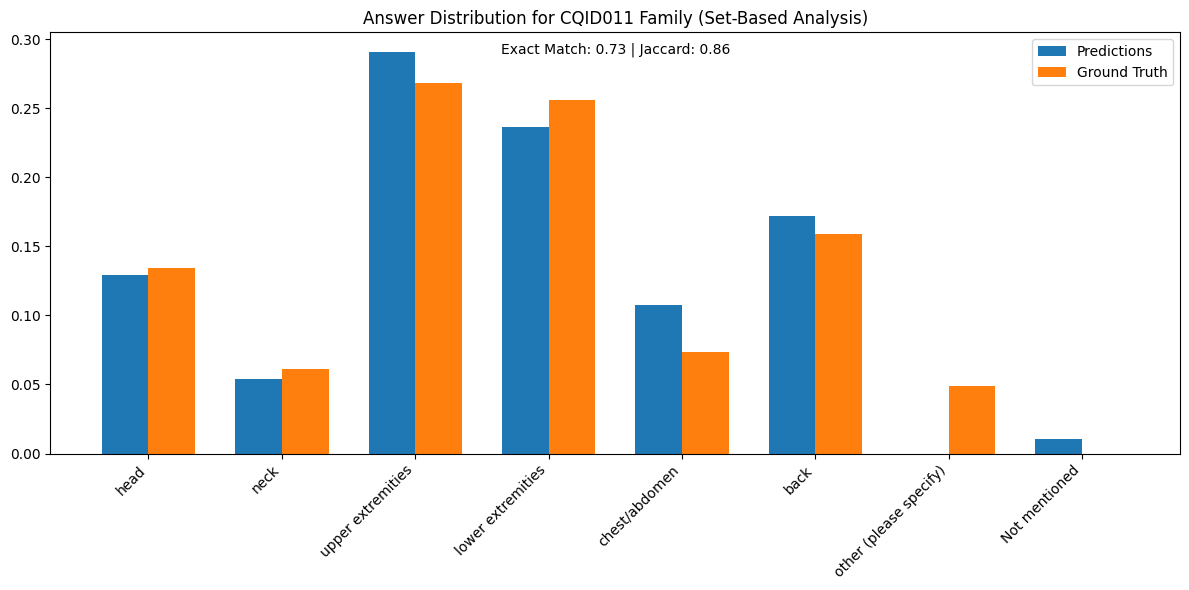

Visualization for CQID012 family:


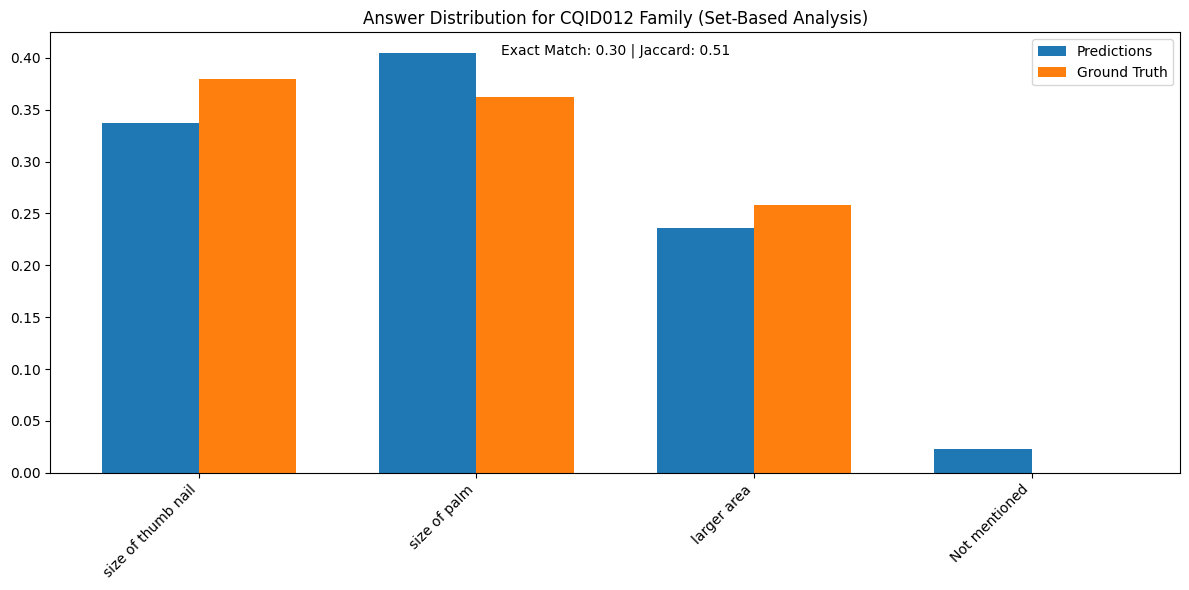

Visualization for CQID020 family:


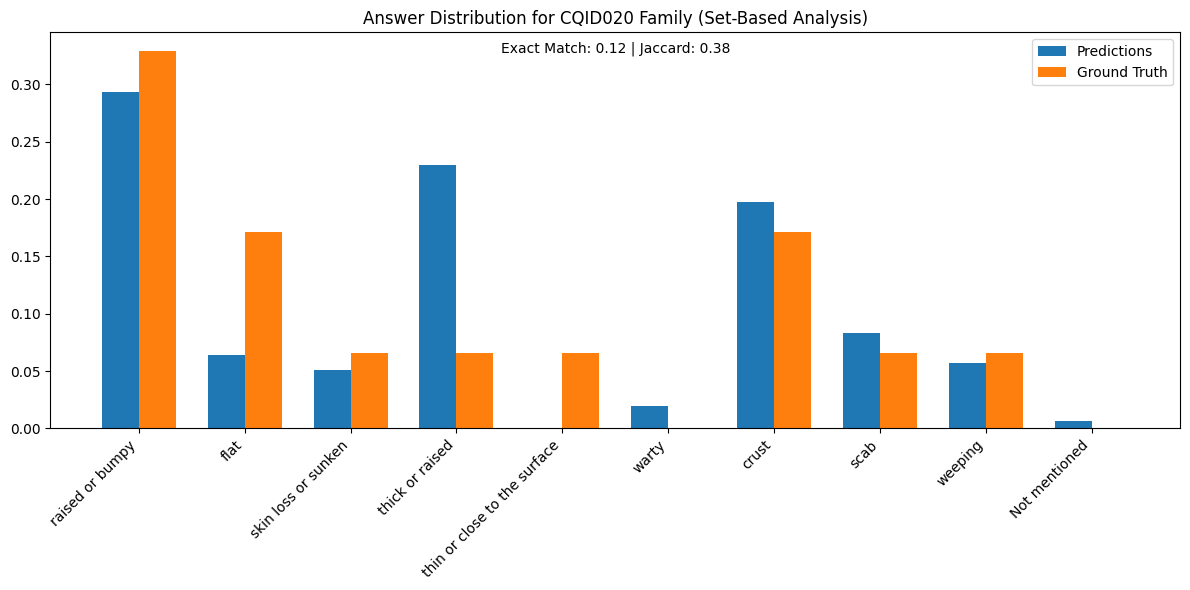

In [10]:
# Function to plot distribution for a question family
def plot_family_distribution(family_id):
    if family_id not in family_results:
        print(f"No analysis results for family {family_id}")
        return
    
    results = family_results[family_id]
    options = results["options"]
    
    # Get counts
    pred_counts = results["pred_option_counts"]
    gt_counts = results["gt_option_counts"]
    
    # Convert to arrays for plotting
    pred_dist = [pred_counts.get(i, 0) for i in range(len(options))]
    gt_dist = [gt_counts.get(i, 0) for i in range(len(options))]
    
    # Normalize distributions
    pred_total = sum(pred_dist)
    gt_total = sum(gt_dist)
    
    if pred_total > 0:
        pred_dist = [count / pred_total for count in pred_dist]
    if gt_total > 0:
        gt_dist = [count / gt_total for count in gt_dist]
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(options))
    width = 0.35
    
    ax.bar(x - width/2, pred_dist, width, label='Predictions')
    ax.bar(x + width/2, gt_dist, width, label='Ground Truth')
    
    ax.set_title(f"Answer Distribution for {family_id} Family (Set-Based Analysis)")
    ax.set_xticks(x)
    ax.set_xticklabels(options, rotation=45, ha='right')
    ax.legend()
    
    # Show both accuracy metrics
    ax.text(0.5, 0.95, f"Exact Match: {results['set_accuracy_exact']:.2f} | Jaccard: {results['set_accuracy_jaccard']:.2f}", 
            transform=ax.transAxes, ha='center')
    
    plt.tight_layout()
    plt.show()

# Plot distributions for special families
for family_id in family_results:
    print(f"Visualization for {family_id} family:")
    plot_family_distribution(family_id)

Plotting all question distributions...

Standard Questions:
Plotting distribution for CQID010-001


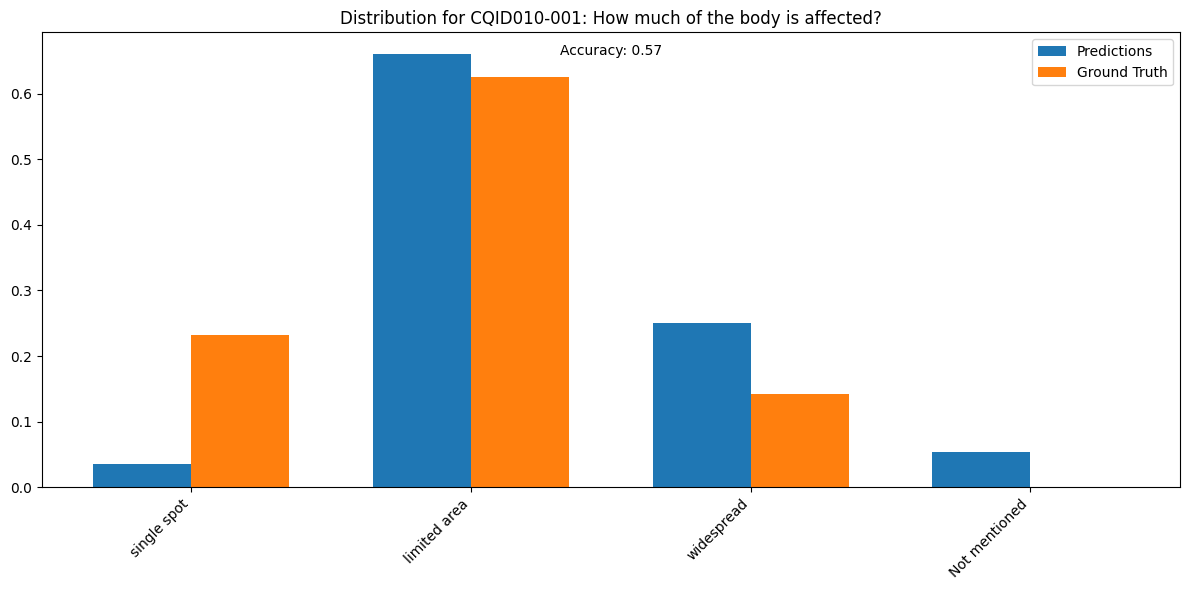

Plotting distribution for CQID015-001


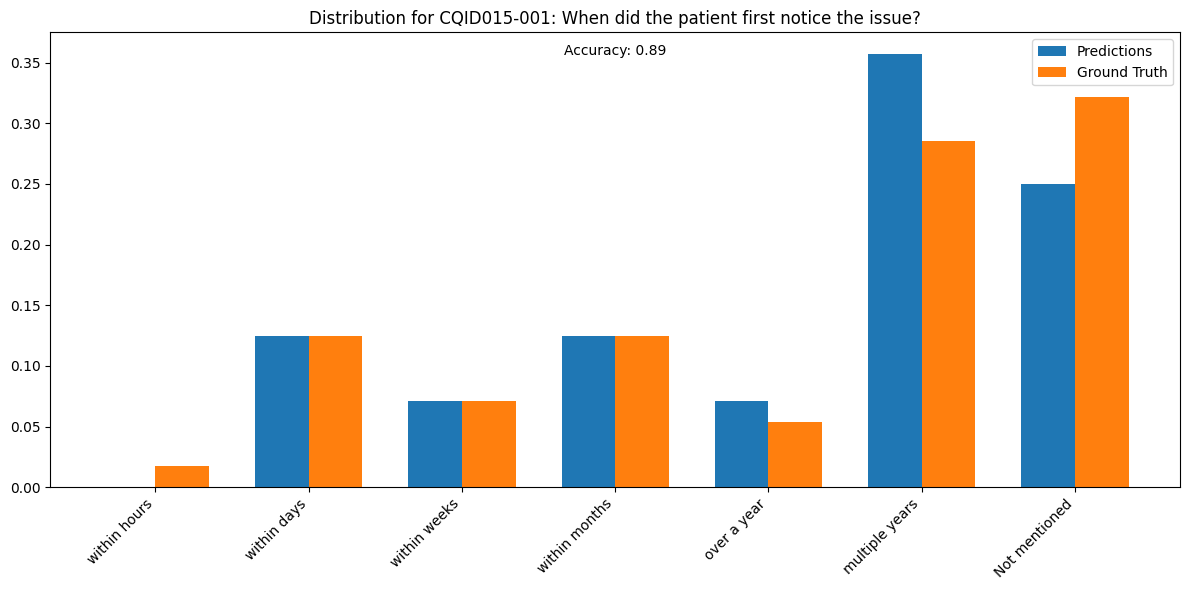

Plotting distribution for CQID025-001


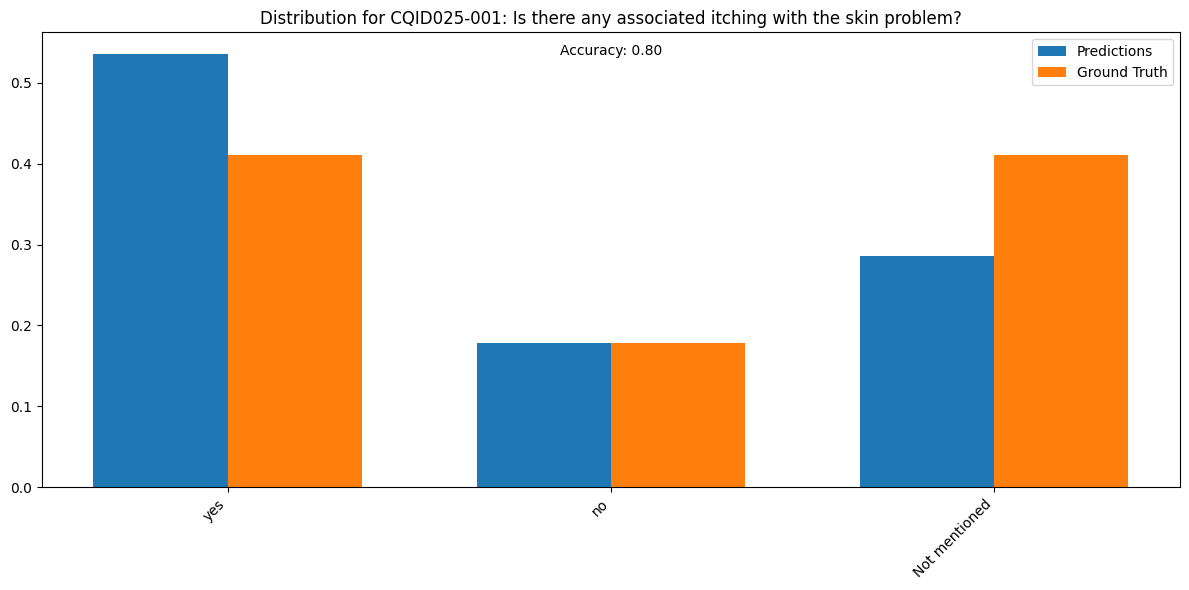

Plotting distribution for CQID034-001


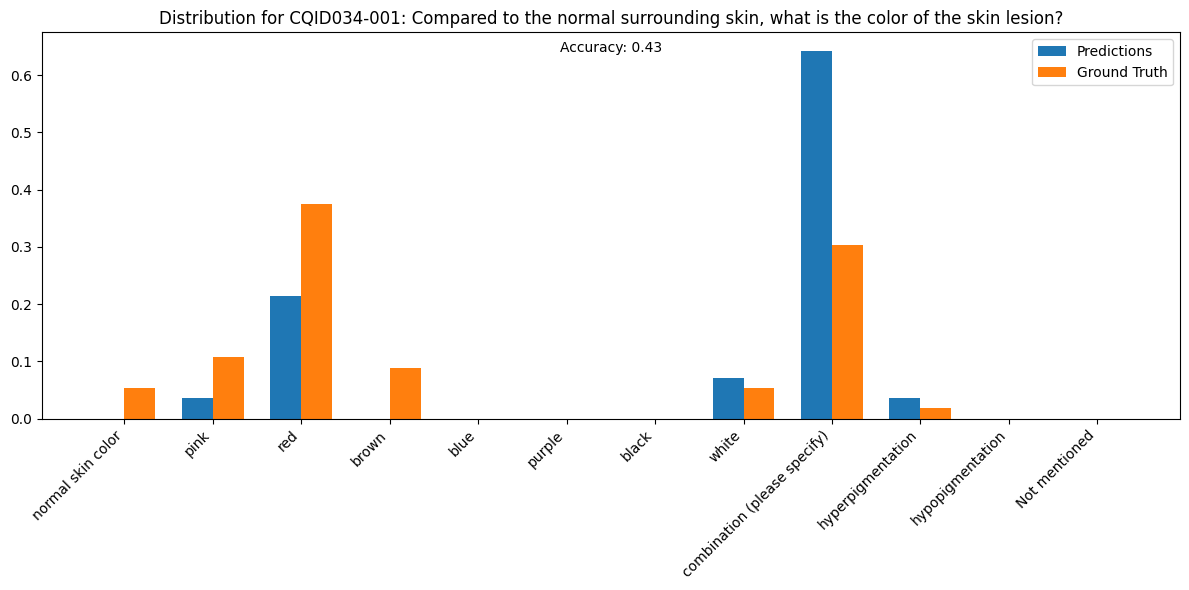

Plotting distribution for CQID035-001


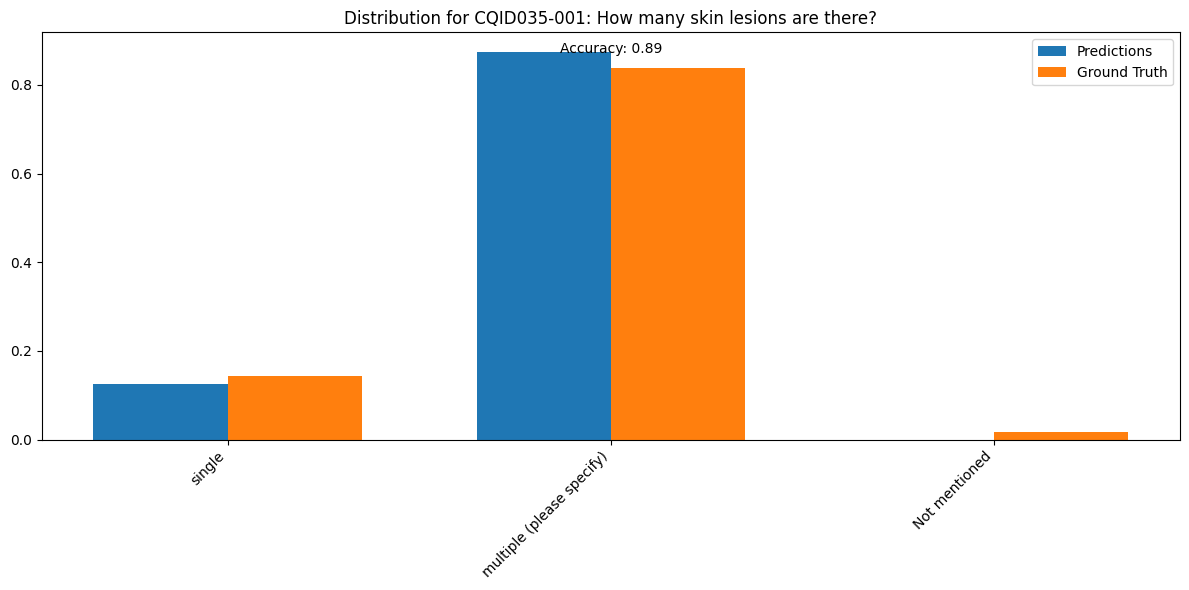

Plotting distribution for CQID036-001


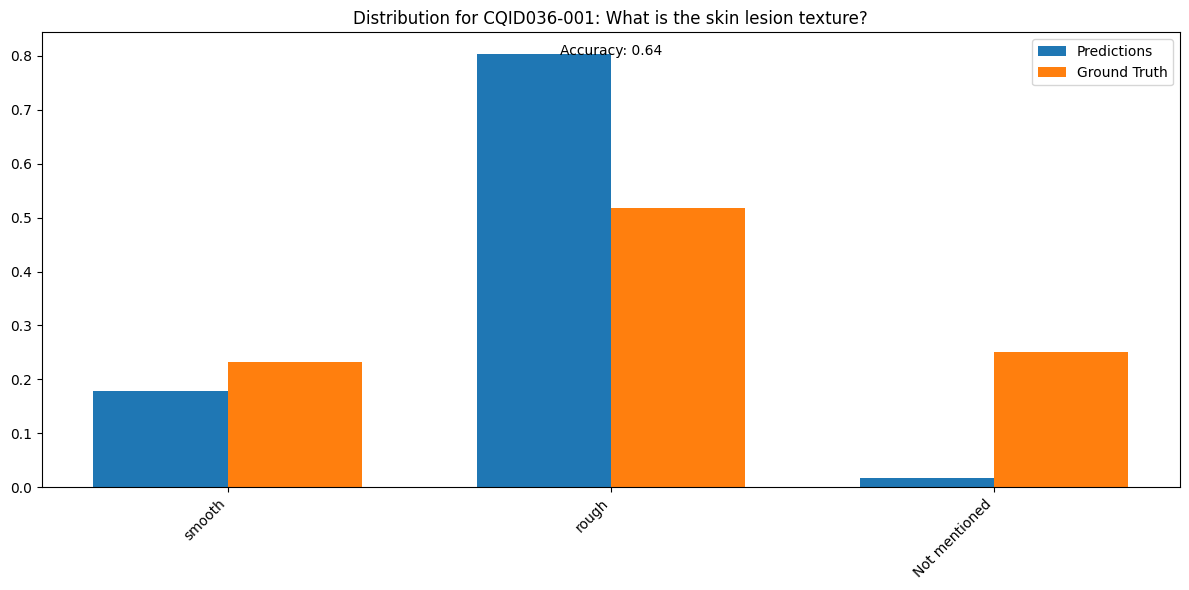


Question Families:
Plotting distribution for CQID011 family


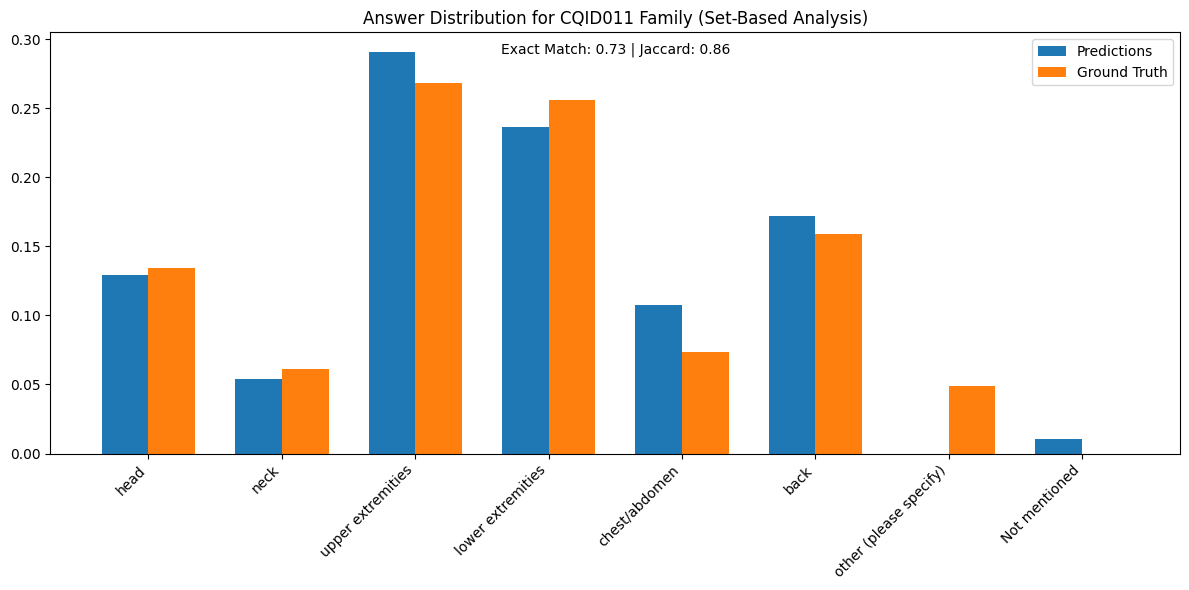

Plotting distribution for CQID012 family


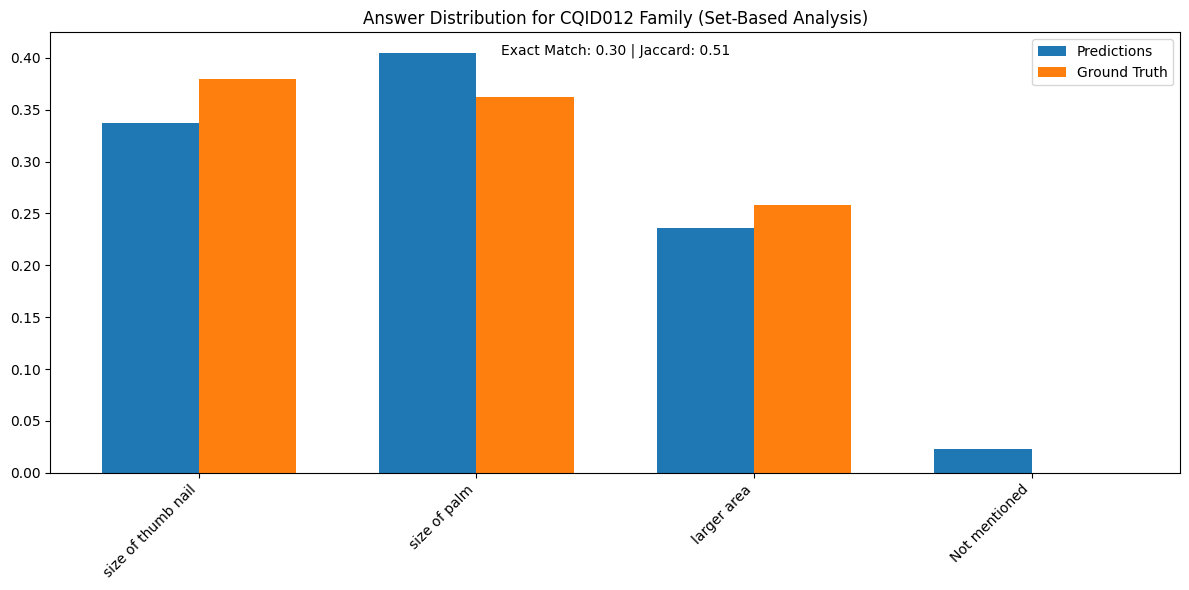

Plotting distribution for CQID020 family


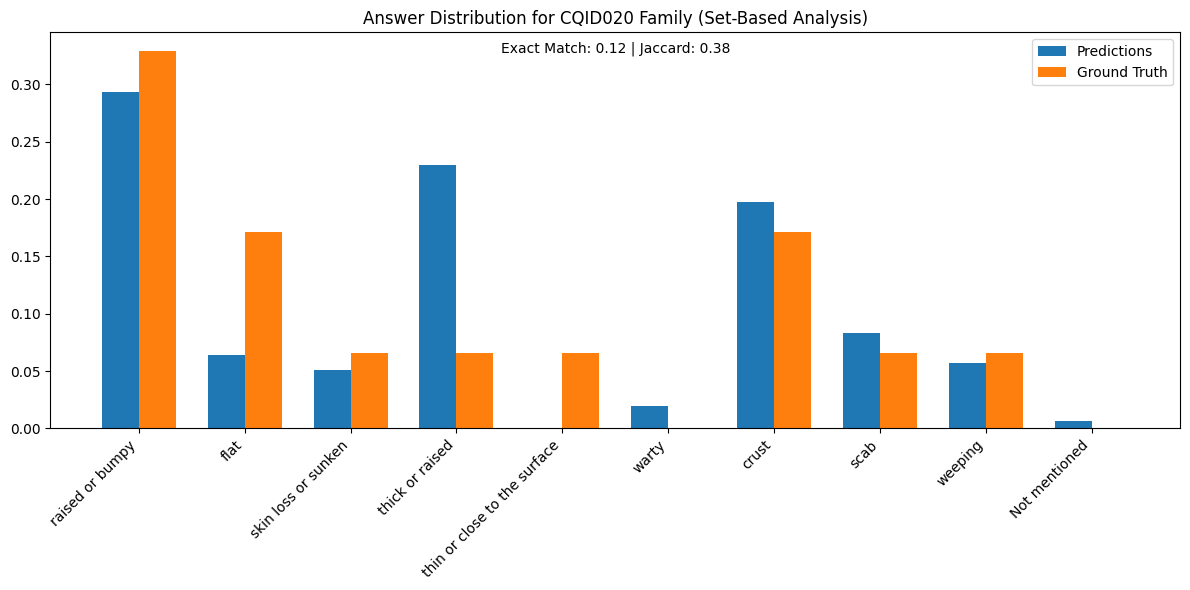

In [11]:
# Plot distributions for all questions in sequential order
print("Plotting all question distributions...")

# Sort question IDs
sorted_questions = sorted(list(all_questions))

# First plot standard questions
print("\nStandard Questions:")
for qid in sorted_questions:
    # Skip special family questions
    if any(qid.startswith(family) for family in special_families):
        continue
    
    print(f"Plotting distribution for {qid}")
    plot_distribution(qid)

# Then plot special family distributions
print("\nQuestion Families:")
for family_id in sorted(family_results.keys()):
    print(f"Plotting distribution for {family_id} family")
    plot_family_distribution(family_id)

In [12]:
# Display distribution information in table format
print("Distribution information in table format:")

# Function to create distribution table for a standard question
def create_distribution_table(qid):
    if qid not in question_map:
        print(f"Question {qid} not found in definitions")
        return None
    
    question = question_map[qid]['question']
    options = question_map[qid]['options']
    
    # Get prediction and ground truth distributions
    pred_dist = [pred_distribution[qid][i] for i in range(len(options))]
    gt_dist = [gt_distribution[qid][i] for i in range(len(options))]
    
    # Calculate percentages
    pred_total = sum(pred_dist)
    gt_total = sum(gt_dist)
    
    pred_pct = [count / pred_total * 100 if pred_total > 0 else 0 for count in pred_dist]
    gt_pct = [count / gt_total * 100 if gt_total > 0 else 0 for count in gt_dist]
    
    # Create dataframe
    df = pd.DataFrame({
        'Option': options,
        'Pred_Count': pred_dist,
        'Pred_Pct': [f"{pct:.1f}%" for pct in pred_pct],
        'GT_Count': gt_dist,
        'GT_Pct': [f"{pct:.1f}%" for pct in gt_pct]
    })
    
    # Add accuracy information
    accuracy = question_accuracy.get(qid, "N/A")
    if accuracy != "N/A":
        accuracy = f"{accuracy:.4f}"
    
    print(f"\nQuestion: {qid} - {question}")
    print(f"Accuracy: {accuracy}")
    return df

# Function to create distribution table for a question family
def create_family_distribution_table(family_id):
    if family_id not in family_results:
        print(f"No analysis results for family {family_id}")
        return None
    
    results = family_results[family_id]
    options = results["options"]
    
    # Get counts
    pred_counts = results["pred_option_counts"]
    gt_counts = results["gt_option_counts"]
    
    # Convert to arrays for table
    pred_dist = [pred_counts.get(i, 0) for i in range(len(options))]
    gt_dist = [gt_counts.get(i, 0) for i in range(len(options))]
    
    # Calculate percentages
    pred_total = results["total_sets"]
    gt_total = results["total_sets"]
    
    pred_pct = [count / pred_total * 100 if pred_total > 0 else 0 for count in pred_dist]
    gt_pct = [count / gt_total * 100 if gt_total > 0 else 0 for count in gt_dist]
    
    # Create dataframe
    df = pd.DataFrame({
        'Option': options,
        'Pred_Count': pred_dist,
        'Pred_Pct': [f"{pct:.1f}%" for pct in pred_pct],
        'GT_Count': gt_dist,
        'GT_Pct': [f"{pct:.1f}%" for pct in gt_pct]
    })
    
    # Add accuracy information
    print(f"\nQuestion Family: {family_id}")
    print(f"Exact Match Accuracy: {results['set_accuracy_exact']:.4f} ({results['correct_sets']}/{results['total_sets']})")
    print(f"Jaccard Similarity (Partial Credit): {results['set_accuracy_jaccard']:.4f}")
    return df

# First display standard questions
print("\nStandard Questions:")
standard_tables = {}
for qid in sorted_questions:
    # Skip special family questions
    if any(qid.startswith(family) for family in special_families):
        continue
    
    df = create_distribution_table(qid)
    if df is not None:
        standard_tables[qid] = df
        display(df)

# Then display special family distributions
print("\nQuestion Families:")
family_tables = {}
for family_id in sorted(family_results.keys()):
    df = create_family_distribution_table(family_id)
    if df is not None:
        family_tables[family_id] = df
        display(df)

# Save tables to CSV files instead of Excel
# Create output directory for CSV files
csv_dir = OUTPUT_DIR / "distribution_tables"
csv_dir.mkdir(exist_ok=True)

# Save standard tables
for qid, df in standard_tables.items():
    safe_qid = qid.replace('-', '_')  # Make filename safe
    csv_file = csv_dir / f"{safe_qid}_distribution.csv"
    df.to_csv(csv_file, index=False)

# Save family tables
for family_id, df in family_tables.items():
    csv_file = csv_dir / f"{family_id}_family_distribution.csv"
    df.to_csv(csv_file, index=False)

print(f"\nAll distribution tables saved to {csv_dir}")

# Create a consolidated table with all questions
all_questions_summary = []

# Add standard questions
for qid in sorted_questions:
    if any(qid.startswith(family) for family in special_families):
        continue
    
    if qid in question_accuracy:
        question_text = question_map.get(qid, {}).get('question', 'Unknown')
        all_questions_summary.append({
            'QID': qid,
            'Question': question_text,
            'Accuracy': question_accuracy[qid],
            'Jaccard_Similarity': 'N/A',  # N/A for standard questions
            'Type': 'Standard',
            'Category': question_map.get(qid, {}).get('category', 'Unknown'),
            'Question_Type': question_map.get(qid, {}).get('type', 'Unknown')
        })

# Add family questions
for family_id, results in family_results.items():
    all_questions_summary.append({
        'QID': family_id,
        'Question': f"Family: {family_id}",
        'Accuracy': results['set_accuracy_exact'],
        'Jaccard_Similarity': results['set_accuracy_jaccard'],
        'Type': 'Family (Set-Based)',
        'Category': question_map.get(results['subquestions'][0], {}).get('category', 'Unknown') if results['subquestions'] else 'Unknown',
        'Question_Type': question_map.get(results['subquestions'][0], {}).get('type', 'Unknown') if results['subquestions'] else 'Unknown'
    })

# Create and save summary table
summary_df = pd.DataFrame(all_questions_summary)
summary_df = summary_df.sort_values('Accuracy', ascending=False)
display(summary_df)

# Save summary
summary_file = csv_dir / "all_questions_summary.csv"
summary_df.to_csv(summary_file, index=False)
print(f"Summary table saved to {summary_file}")

Distribution information in table format:

Standard Questions:

Question: CQID010-001 - How much of the body is affected?
Accuracy: 0.5714


,Option,Pred_Count,Pred_Pct,GT_Count,GT_Pct
0,single spot,2,3.6%,13,23.2%
1,limited area,37,66.1%,35,62.5%
2,widespread,14,25.0%,8,14.3%
3,Not mentioned,3,5.4%,0,0.0%



Question: CQID015-001 - When did the patient first notice the issue?
Accuracy: 0.8929


,Option,Pred_Count,Pred_Pct,GT_Count,GT_Pct
0,within hours,0,0.0%,1,1.8%
1,within days,7,12.5%,7,12.5%
2,within weeks,4,7.1%,4,7.1%
3,within months,7,12.5%,7,12.5%
4,over a year,4,7.1%,3,5.4%
5,multiple years,20,35.7%,16,28.6%
6,Not mentioned,14,25.0%,18,32.1%



Question: CQID025-001 - Is there any associated itching with the skin problem?
Accuracy: 0.8036


,Option,Pred_Count,Pred_Pct,GT_Count,GT_Pct
0,yes,30,53.6%,23,41.1%
1,no,10,17.9%,10,17.9%
2,Not mentioned,16,28.6%,23,41.1%



Question: CQID034-001 - Compared to the normal surrounding skin, what is the color of the skin lesion?
Accuracy: 0.4286


,Option,Pred_Count,Pred_Pct,GT_Count,GT_Pct
0,normal skin color,0,0.0%,3,5.4%
1,pink,2,3.6%,6,10.7%
2,red,12,21.4%,21,37.5%
3,brown,0,0.0%,5,8.9%
4,blue,0,0.0%,0,0.0%
5,purple,0,0.0%,0,0.0%
6,black,0,0.0%,0,0.0%
7,white,4,7.1%,3,5.4%
8,combination (please specify),36,64.3%,17,30.4%
9,hyperpigmentation,2,3.6%,1,1.8%



Question: CQID035-001 - How many skin lesions are there?
Accuracy: 0.8929


,Option,Pred_Count,Pred_Pct,GT_Count,GT_Pct
0,single,7,12.5%,8,14.3%
1,multiple (please specify),49,87.5%,47,83.9%
2,Not mentioned,0,0.0%,1,1.8%



Question: CQID036-001 - What is the skin lesion texture?
Accuracy: 0.6429


,Option,Pred_Count,Pred_Pct,GT_Count,GT_Pct
0,smooth,10,17.9%,13,23.2%
1,rough,45,80.4%,29,51.8%
2,Not mentioned,1,1.8%,14,25.0%



Question Families:

Question Family: CQID011
Exact Match Accuracy: 0.7321 (41/56)
Jaccard Similarity (Partial Credit): 0.8616


,Option,Pred_Count,Pred_Pct,GT_Count,GT_Pct
0,head,12,21.4%,11,19.6%
1,neck,5,8.9%,5,8.9%
2,upper extremities,27,48.2%,22,39.3%
3,lower extremities,22,39.3%,21,37.5%
4,chest/abdomen,10,17.9%,6,10.7%
5,back,16,28.6%,13,23.2%
6,other (please specify),0,0.0%,4,7.1%
7,Not mentioned,1,1.8%,0,0.0%



Question Family: CQID012
Exact Match Accuracy: 0.3036 (17/56)
Jaccard Similarity (Partial Credit): 0.5149


,Option,Pred_Count,Pred_Pct,GT_Count,GT_Pct
0,size of thumb nail,30,53.6%,22,39.3%
1,size of palm,36,64.3%,21,37.5%
2,larger area,21,37.5%,15,26.8%
3,Not mentioned,2,3.6%,0,0.0%



Question Family: CQID020
Exact Match Accuracy: 0.1250 (7/56)
Jaccard Similarity (Partial Credit): 0.3839


,Option,Pred_Count,Pred_Pct,GT_Count,GT_Pct
0,raised or bumpy,46,82.1%,25,44.6%
1,flat,10,17.9%,13,23.2%
2,skin loss or sunken,8,14.3%,5,8.9%
3,thick or raised,36,64.3%,5,8.9%
4,thin or close to the surface,0,0.0%,5,8.9%
5,warty,3,5.4%,0,0.0%
6,crust,31,55.4%,13,23.2%
7,scab,13,23.2%,5,8.9%
8,weeping,9,16.1%,5,8.9%
9,Not mentioned,1,1.8%,0,0.0%



All distribution tables saved to outputs\distribution_tables


,QID,Question,Accuracy,Jaccard_Similarity,Type,Category,Question_Type
1,CQID015-001,When did the patient first notice the issue?,0.892857,N/A,Standard,General,Onset
4,CQID035-001,How many skin lesions are there?,0.892857,N/A,Standard,Skin Specific,Lesion Count
2,CQID025-001,Is there any associated itching with the skin ...,0.803571,N/A,Standard,Skin Specific,Itch
6,CQID011,Family: CQID011,0.732143,0.861607,Family (Set-Based),General,Site Location
5,CQID036-001,What is the skin lesion texture?,0.642857,N/A,Standard,Skin Specific,Texture
0,CQID010-001,How much of the body is affected?,0.571429,N/A,Standard,General,Site
3,CQID034-001,"Compared to the normal surrounding skin, what ...",0.428571,N/A,Standard,Skin Specific,Lesion Color
7,CQID012,Family: CQID012,0.303571,0.514881,Family (Set-Based),General,Size
8,CQID020,Family: CQID020,0.125000,0.383929,Family (Set-Based),Skin Specific,Skin Description


Summary table saved to outputs\distribution_tables\all_questions_summary.csv


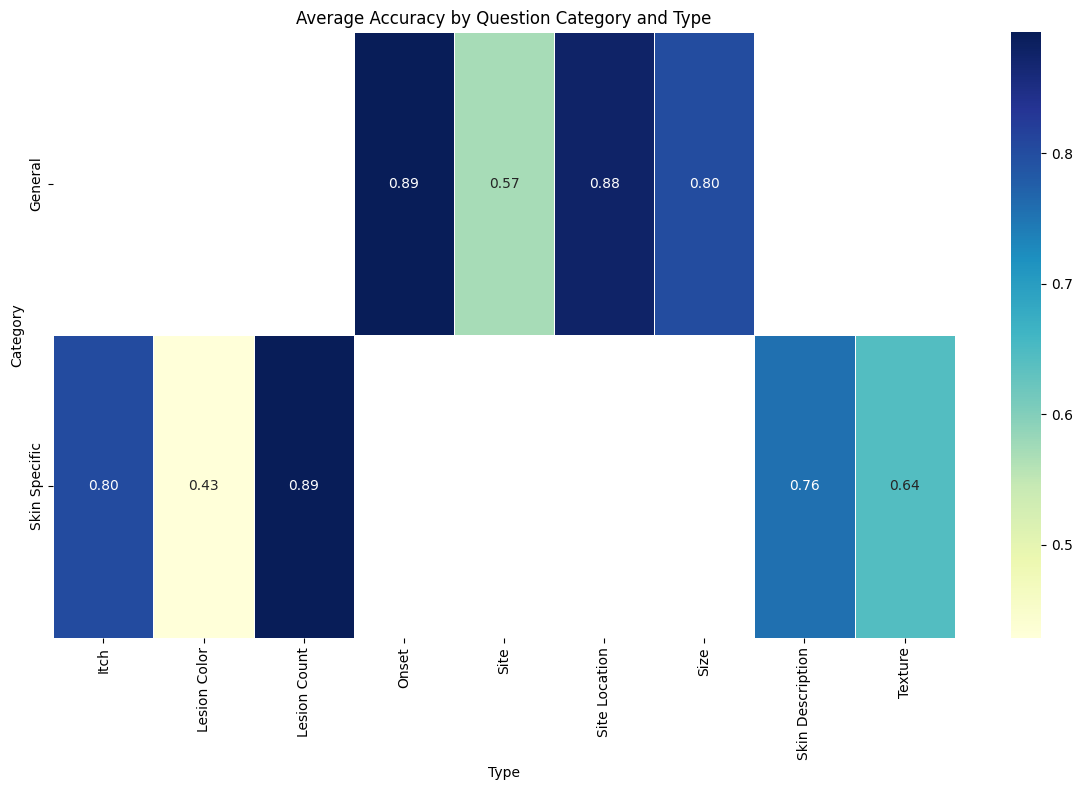

In [13]:
# Group accuracy by category and type
pivot_df = accuracy_df.pivot_table(
    values='Accuracy', 
    index='Category', 
    columns='Type', 
    aggfunc='mean'
)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
plt.title('Average Accuracy by Question Category and Type')
plt.tight_layout()
plt.show()

In [14]:
# Function to analyze errors for a question
def analyze_errors(qid):
    if qid not in question_errors or not question_errors[qid]:
        print(f"No errors found for question {qid}")
        return
    
    errors = question_errors[qid]
    error_counts = Counter([(error['pred'], error['gt']) for error in errors])
    
    # Display the most common errors
    print(f"Most common errors for {qid} ({question_map[qid]['question'] if qid in question_map else 'Unknown'}):\n")
    for (pred, gt), count in error_counts.most_common(5):
        print(f"  Predicted: '{pred}' | Ground Truth: '{gt}' | Count: {count}")

# Analyze errors for the questions with lowest accuracy
lowest_accuracy = accuracy_df.sort_values('Accuracy').head(5)['QID']
for qid in lowest_accuracy:
    analyze_errors(qid)
    print()

Most common errors for CQID020-002 (2 What label best describes the affected area?):

  Predicted: 'thick or raised' | Ground Truth: 'Not mentioned' | Count: 15
  Predicted: 'crust' | Ground Truth: 'Not mentioned' | Count: 7
  Predicted: 'raised or bumpy' | Ground Truth: 'Not mentioned' | Count: 5
  Predicted: 'crust' | Ground Truth: 'scab' | Count: 2
  Predicted: 'skin loss or sunken' | Ground Truth: 'Not mentioned' | Count: 2

Most common errors for CQID034-001 (Compared to the normal surrounding skin, what is the color of the skin lesion?):

  Predicted: 'combination (please specify)' | Ground Truth: 'red' | Count: 14
  Predicted: 'combination (please specify)' | Ground Truth: 'brown' | Count: 4
  Predicted: 'combination (please specify)' | Ground Truth: 'pink' | Count: 3
  Predicted: 'red' | Ground Truth: 'pink' | Count: 2
  Predicted: 'red' | Ground Truth: 'combination (please specify)' | Count: 2

Most common errors for CQID020-003 (3 What label best describes the affected area?)

In [15]:
# Calculate overall accuracy for standard questions
standard_accuracy = accuracy_df['Accuracy'].mean()
print(f"Overall accuracy across standard questions: {standard_accuracy:.4f}")

# Group accuracy by category
category_accuracy = accuracy_df.groupby('Category')['Accuracy'].mean()
print("\nAccuracy by Category:")
print(category_accuracy)

# Group accuracy by type
type_accuracy = accuracy_df.groupby('Type')['Accuracy'].mean()
print("\nAccuracy by Type:")
print(type_accuracy)

# Combined accuracy including set-based accuracy for special families
all_accuracies = list(question_accuracy.values())
family_set_accuracies = [results['set_accuracy'] for results in family_results.values()]
combined_accuracy = np.mean(all_accuracies + family_set_accuracies)
print(f"\nCombined accuracy (including set-based family accuracy): {combined_accuracy:.4f}")

# Visualize overall distribution of accuracy
plt.figure(figsize=(10, 6))
sns.histplot(accuracy_df['Accuracy'], bins=20, kde=True)
plt.axvline(x=standard_accuracy, color='r', linestyle='--', label=f'Mean: {standard_accuracy:.2f}')
plt.title('Distribution of Question Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

Overall accuracy across standard questions: 0.7817

Accuracy by Category:
Category
General          0.823980
Skin Specific    0.736264
Name: Accuracy, dtype: float64

Accuracy by Type:
Type
Itch                0.803571
Lesion Color        0.428571
Lesion Count        0.892857
Onset               0.892857
Site                0.571429
Site Location       0.877976
Size                0.800595
Skin Description    0.755952
Texture             0.642857
Name: Accuracy, dtype: float64


KeyError: 'set_accuracy'

In [ ]:
def explore_question(qid=None):
    # Check if this is a question family base ID
    if qid in question_families and qid in special_families:
        print(f"Exploring question family {qid}")
        if qid in family_results:
            results = family_results[qid]
            
            print(f"Question family: {qid}")
            print(f"Subquestions: {results['subquestions']}")
            print(f"Set-based accuracy: {results['set_accuracy']:.4f} ({results['correct_sets']}/{results['total_sets']})")
            
            # Display answer distributions
            options = results["options"]
            print("\nAnswer distributions in sets:")
            
            print("\nPredictions:")
            for i, option in enumerate(options):
                count = results["pred_option_counts"].get(i, 0)
                total = results["total_sets"]
                if total > 0:
                    print(f"  {option}: {count}/{total} ({count/total:.2%})")
            
            print("\nGround Truth:")
            for i, option in enumerate(options):
                count = results["gt_option_counts"].get(i, 0)
                total = results["total_sets"]
                if total > 0:
                    print(f"  {option}: {count}/{total} ({count/total:.2%})")
            
            # Plot family distribution
            plot_family_distribution(qid)
        else:
            print(f"No analysis results available for family {qid}")
        return
    
    # For individual questions or non-special families
    if qid is None or qid not in all_questions:
        # List all available questions
        question_list = []
        for qid in all_questions:
            if qid in question_map:
                question_list.append({
                    'QID': qid,
                    'Question': question_map[qid]['question'],
                    'Accuracy': question_accuracy.get(qid, 'N/A')
                })
        
        # Also list special families
        for family_id in special_families:
            if family_id in family_results:
                question_list.append({
                    'QID': family_id,
                    'Question': f"[FAMILY] {family_id}",
                    'Accuracy': family_results[family_id]['set_accuracy']
                })
        
        # Display available questions
        df = pd.DataFrame(question_list)
        print("Available questions and families (sorted by ID):")
        return df.sort_values('QID')
    
    # Display detailed information about the question
    print(f"Question ID: {qid}")
    
    if qid in question_map:
        print(f"Question: {question_map[qid]['question']}")
        print(f"Category: {question_map[qid]['category']}")
        print(f"Type: {question_map[qid]['type']}")
        print(f"Options: {question_map[qid]['options']}")
    
    if qid in question_accuracy:
        print(f"\nAccuracy: {question_accuracy[qid]:.4f}")
    
    # Display prediction and ground truth distributions
    print("\nPrediction Distribution:")
    if qid in pred_text_dist:
        for option, count in sorted(pred_text_dist[qid].items(), key=lambda x: -x[1]):
            total = sum(pred_text_dist[qid].values())
            print(f"  {option}: {count} ({count/total:.2%})")
    
    print("\nGround Truth Distribution:")
    if qid in gt_text_dist:
        for option, count in sorted(gt_text_dist[qid].items(), key=lambda x: -x[1]):
            total = sum(gt_text_dist[qid].values())
            print(f"  {option}: {count} ({count/total:.2%})")
    
    # Plot the distribution
    plot_distribution(qid)
    
    # Analyze errors
    if qid in question_errors and question_errors[qid]:
        print("\nCommon Errors:")
        analyze_errors(qid)

# Example usage:
# Display all questions and families
explore_question()

Available questions and families (sorted by ID):


,QID,Question,Accuracy
7,CQID010-001,How much of the body is affected?,0.571429
27,CQID011,[FAMILY] CQID011,0.732143
10,CQID011-001,1 Where is the affected area?,0.785714
0,CQID011-002,2 Where is the affected area?,0.714286
16,CQID011-003,3 Where is the affected area?,0.892857
3,CQID011-004,4 Where is the affected area?,0.910714
14,CQID011-005,5 Where is the affected area?,0.982143
8,CQID011-006,6 Where is the affected area?,0.982143
28,CQID012,[FAMILY] CQID012,0.303571
11,CQID012-001,1 How large are the affected areas? Please spe...,0.535714


Confusion Matrix for High Accuracy Question:


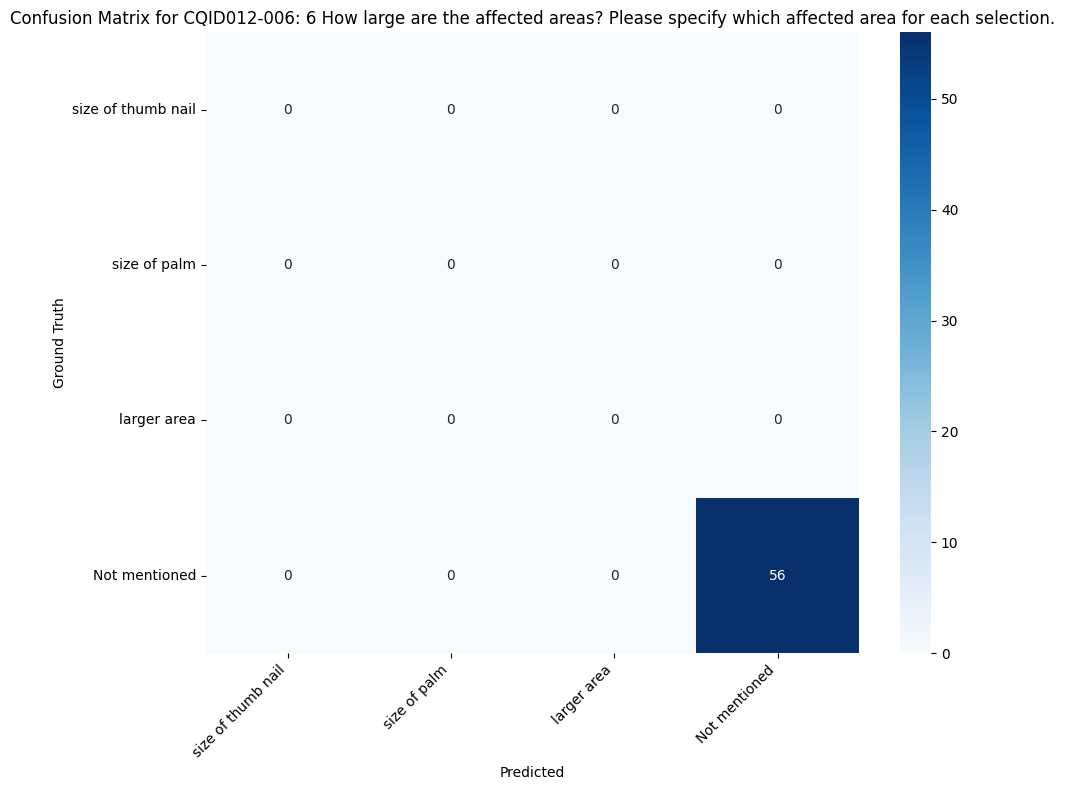


Confusion Matrix for Medium Accuracy Question:


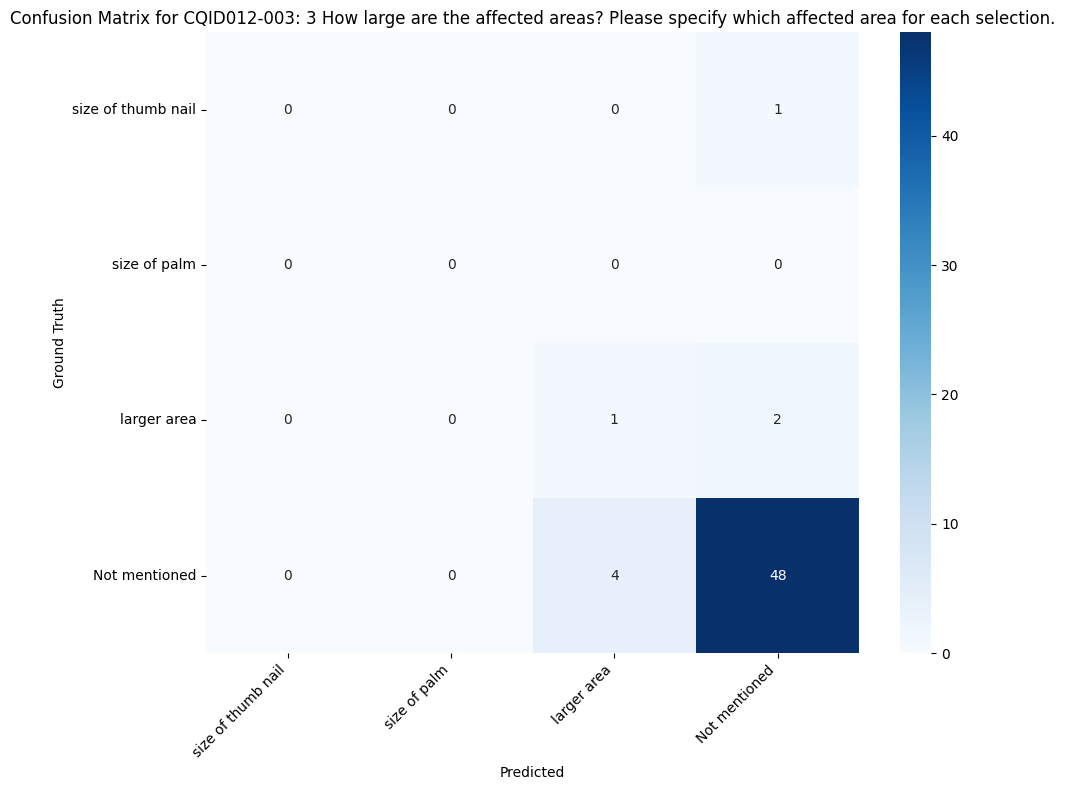


Confusion Matrix for Low Accuracy Question:


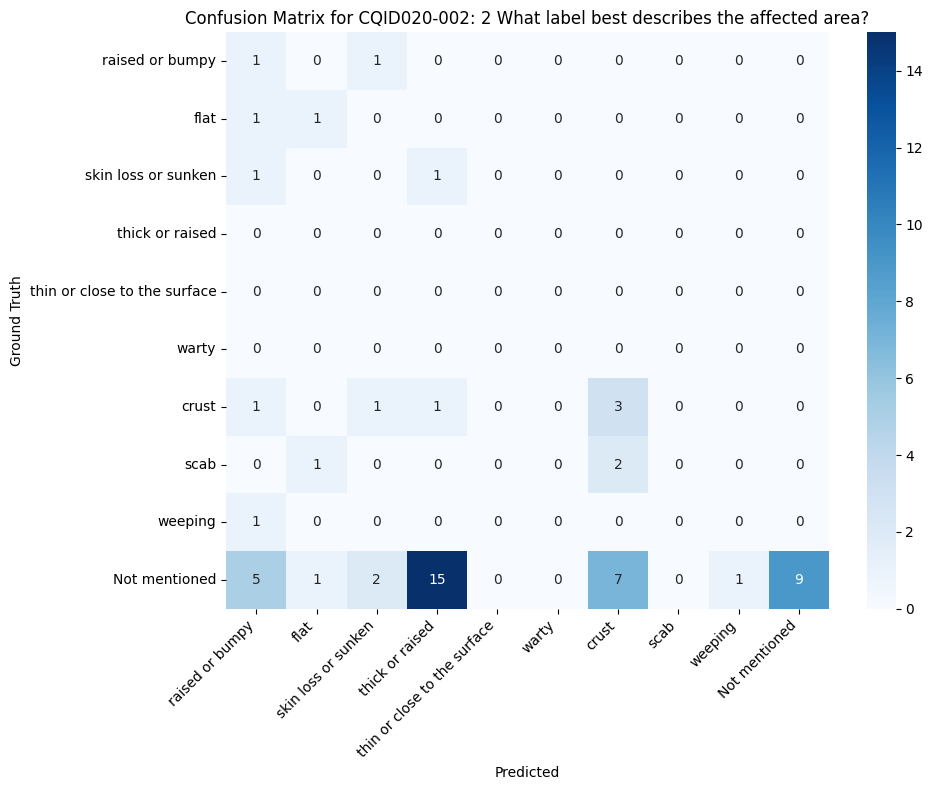

In [ ]:
def plot_confusion_matrix(qid):
    if qid not in question_map:
        print(f"Question {qid} not found in definitions")
        return
    
    options = question_map[qid]['options']
    n_options = len(options)
    
    # Initialize confusion matrix
    cm = np.zeros((n_options, n_options), dtype=int)
    
    # Fill the confusion matrix
    for encounter_id in set(pred_dict.keys()).intersection(gt_dict.keys()):
        pred = pred_dict[encounter_id]
        gt = gt_dict[encounter_id]
        
        if qid in pred and qid in gt:
            pred_val = pred[qid]
            gt_val = gt[qid]
            
            if pred_val < n_options and gt_val < n_options:
                cm[gt_val][pred_val] += 1
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=options, yticklabels=options)
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title(f"Confusion Matrix for {qid}: {question_map[qid]['question']}")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for a few sample questions with different accuracy levels
# Choose questions with different accuracy levels
if len(accuracy_df) > 0:
    high_acc = accuracy_df.sort_values('Accuracy', ascending=False).iloc[0]['QID']
    mid_acc = accuracy_df.sort_values('Accuracy').iloc[len(accuracy_df)//2]['QID']
    low_acc = accuracy_df.sort_values('Accuracy').iloc[0]['QID']

    print("Confusion Matrix for High Accuracy Question:")
    plot_confusion_matrix(high_acc)

    print("\nConfusion Matrix for Medium Accuracy Question:")
    plot_confusion_matrix(mid_acc)

    print("\nConfusion Matrix for Low Accuracy Question:")
    plot_confusion_matrix(low_acc)

In [ ]:
def analyze_family_mismatches(family_id):
    if family_id not in family_results:
        print(f"No analysis results for family {family_id}")
        return
    
    results = family_results[family_id]
    subquestions = results["subquestions"]
    options = results["options"]
    not_mentioned_idx = results["not_mentioned_idx"]
    
    # Track mismatched sets
    mismatches = []
    
    for encounter_id in set(pred_dict.keys()).intersection(gt_dict.keys()):
        pred = pred_dict[encounter_id]
        gt = gt_dict[encounter_id]
        
        # Skip if not all subquestions exist
        if not all(qid in pred and qid in gt for qid in subquestions):
            continue
        
        # Get sets of answers (excluding "Not mentioned" padding)
        pred_set = set()
        gt_set = set()
        
        for qid in subquestions:
            pred_val = pred[qid]
            gt_val = gt[qid]
            
            if pred_val != not_mentioned_idx or len(subquestions) == 1:
                pred_set.add(pred_val)
            
            if gt_val != not_mentioned_idx or len(subquestions) == 1:
                gt_set.add(gt_val)
        
        # Special case: if all answers were "Not mentioned", add it back as a valid single answer
        if not pred_set and not_mentioned_idx is not None:
            pred_set.add(not_mentioned_idx)
        if not gt_set and not_mentioned_idx is not None:
            gt_set.add(not_mentioned_idx)
        
        # If sets don't match, record the mismatch
        if pred_set != gt_set:
            mismatches.append({
                "encounter_id": encounter_id,
                "pred_set": pred_set,
                "gt_set": gt_set
            })
    
    # Count common mismatch patterns
    mismatch_patterns = Counter()
    
    for mismatch in mismatches:
        pred_text = ", ".join(sorted([convert_to_text(subquestions[0], val) for val in mismatch["pred_set"]]))
        gt_text = ", ".join(sorted([convert_to_text(subquestions[0], val) for val in mismatch["gt_set"]]))
        mismatch_patterns[(pred_text, gt_text)] += 1
    
    print(f"\nAnalyzing set mismatches for family {family_id}:")
    print(f"Total mismatches: {len(mismatches)}/{results['total_sets']} ({len(mismatches)/results['total_sets']:.2%})")
    
    print("\nMost common mismatch patterns:")
    for (pred_text, gt_text), count in mismatch_patterns.most_common(5):
        print(f"  Predicted: [{pred_text}] | Ground Truth: [{gt_text}] | Count: {count}")

# Analyze mismatches for each special family
for family_id in family_results:
    analyze_family_mismatches(family_id)


Analyzing set mismatches for family CQID011:
Total mismatches: 15/56 (26.79%)

Most common mismatch patterns:
  Predicted: [lower extremities, upper extremities] | Ground Truth: [lower extremities] | Count: 2
  Predicted: [back, chest/abdomen] | Ground Truth: [back] | Count: 2
  Predicted: [back] | Ground Truth: [back, other (please specify)] | Count: 1
  Predicted: [back, lower extremities] | Ground Truth: [lower extremities] | Count: 1
  Predicted: [back, chest/abdomen, head, upper extremities] | Ground Truth: [head, upper extremities] | Count: 1

Analyzing set mismatches for family CQID012:
Total mismatches: 39/56 (69.64%)

Most common mismatch patterns:
  Predicted: [size of palm, size of thumb nail] | Ground Truth: [size of thumb nail] | Count: 9
  Predicted: [larger area, size of palm] | Ground Truth: [size of palm] | Count: 4
  Predicted: [size of palm] | Ground Truth: [larger area] | Count: 4
  Predicted: [size of palm, size of thumb nail] | Ground Truth: [size of palm] | Coun

In [ ]:
# Save accuracy results
output_file = OUTPUT_DIR / "prediction_analysis_results.csv"
accuracy_df.to_csv(output_file)
print(f"Standard analysis results saved to {output_file}")

# Create a more comprehensive report
report = {
    'standard_accuracy': standard_accuracy,
    'accuracy_by_category': category_accuracy.to_dict(),
    'accuracy_by_type': type_accuracy.to_dict(),
    'question_accuracy': question_accuracy,
    'family_results': {k: {
        'set_accuracy': v['set_accuracy'],
        'correct_sets': v['correct_sets'],
        'total_sets': v['total_sets'],
        'subquestions': v['subquestions']
    } for k, v in family_results.items()},
    'prediction_distribution': {k: dict(v) for k, v in pred_distribution.items()},
    'ground_truth_distribution': {k: dict(v) for k, v in gt_distribution.items()}
}

report_file = OUTPUT_DIR / "prediction_analysis_report.json"
with open(report_file, 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2)
print(f"Comprehensive report saved to {report_file}")

Standard analysis results saved to outputs\prediction_analysis_results.csv
Comprehensive report saved to outputs\prediction_analysis_report.json
